# 8-7. 프로젝트: 한영 번역기 만들기

## Step 0. Import

In [20]:
!mkdir -p ~/aiffel/s2s_translation #프로젝트를 위한 디렉토리 생성
!sudo apt -qq -y install fonts-nanum #나눔글꼴 설치

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 110 not upgraded.


In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [22]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.4.1


## Step 1. 데이터 다운로드

### 데이터 다운
https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.train.tar.gz
    
- 압축해제: tar -xvf korean-english-park.train.tar.gz

In [121]:
path_ko = os.getenv('HOME')+"/aiffel/GD08_data/korean-english-park.train.ko"
path_en = os.getenv('HOME')+"/aiffel/GD08_data/korean-english-park.train.en"

In [122]:
with open(path_ko, "r") as f:
    raw_ko = f.read().splitlines()

print("Data Size:", len(raw_ko))
print("Example:")

for sen in raw_ko[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [123]:
type(raw_ko)

list

In [124]:
with open(path_en, "r") as f:
    raw_en = f.read().splitlines()

print("Data Size:", len(raw_en))
print("Example:")

for sen in raw_en[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


## Step 2. 데이터 정제

In [125]:
from konlpy.tag import Mecab
mecab = Mecab()

### 1) 중복된 데이터를 제거
- set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거
- 데이터의 병렬 쌍이 흐트러지지 않게 주의
- 중복을 제거한 데이터를 cleaned_corpus 에 저장

In [126]:
raw_ko = list(set(raw_ko))
raw_en = list(set(raw_en))

In [130]:
print("Data Size:", len(raw_ko))

Data Size: 77591


In [131]:
print("Data Size:", len(set(raw_en)))

Data Size: 75598


- 중복된 데이터를 제거하니 94123 -> 77591 로 줄었다.

### 2) 한글용 preprocessing() 함수 
- 한글에 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의
- 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다. 
    - konlpy 설치 : https://konlpy.org/en/latest/install/

In [133]:
#rawko 전처리 함수
def preprocess_raw_ko(sentences):
    result = []
    for sentence in sentences:
        #불필요한 이상한 기호가 존재, 특수문자는 불필요한 노이즈로 작용할 수 있기 때문에 삭제
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        #한글에 적용할 수 있는 정규식 추가
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
        #한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다
        sentence = mecab.morphs(sentence)
    #     sentence = sentence.strip()
    #         print(type(sentence))
        result.append(sentence)
    return result

### 3) 타겟 언어(영문)에 토큰 추가
- start 토큰과 end 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 

In [145]:
#rawen(target) 전처리함수
def preprocess_raw_en(sentences):
    result = []
    for sentence in sentences:
        sentence = sentence.lower().strip()

        #불필요한 이상한 기호가 존재, 특수문자는 불필요한 노이즈로 작용할 수 있기 때문에 삭제
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()
        sentence = '<start> ' + sentence
        sentence = sentence + ' <end>'
        sentence = sentence.strip()
        sentence = sentence.split()

        result.append(sentence)
    return result

불필요한 이상한 기호가 존재, 특수문자는 불필요한 노이즈로 작용할 수 있기 때문에 삭제하자

In [146]:
ko_corpus = []
en_corpus = []
#rawko
ko_corpus.append(preprocess_raw_ko(raw_ko))

#rawen
en_corpus.append(preprocess_raw_en(raw_en))   

In [147]:
ko_corpus[0]

[['경찰',
  '이',
  '도착',
  '했',
  '을',
  '때',
  '그',
  '는',
  '도축장',
  '에서',
  '쓰이',
  '는',
  '칼',
  '로',
  '자해',
  ',',
  '동맥',
  '을',
  '끊',
  '었',
  '다',
  '.'],
 ['영국',
  '제조업체인',
  '드루',
  '비전',
  '사',
  '는',
  '5000',
  '투',
  '시',
  '카메라',
  '가',
  '사람',
  '이',
  '움직이',
  '지',
  '않',
  '거나',
  '움직여도',
  '옷',
  '속',
  '에',
  '있',
  '는',
  '금속',
  '물체',
  '와',
  '비금속',
  '물체',
  '를',
  '감지',
  '하',
  '며',
  '인체',
  '의',
  '실루엣',
  '만',
  '나타내',
  '기',
  '때문',
  '에',
  '신체',
  '표면',
  '을',
  '구체',
  '적',
  '으로',
  '보여',
  '주',
  '지',
  '는',
  '않',
  '는다고',
  '설명',
  '했',
  '다',
  '.'],
 ['캐',
  '이길',
  '대변인',
  '은',
  '이',
  '같',
  '은',
  '사고',
  '는',
  '흔한',
  '것',
  '이',
  '다',
  '며',
  '테러',
  '와',
  '연관',
  '된',
  '것',
  '으로',
  '보이',
  '는',
  '정황',
  '은',
  '발견',
  '되',
  '지',
  '않',
  '았',
  '다',
  '고',
  '말',
  '했',
  '다',
  '.'],
 ['원문',
  '기사',
  '보',
  '기',
  '세계',
  '적',
  '금융',
  '위기',
  '를',
  '해결',
  '하',
  '기',
  '위',
  '힌',
  '세계',
  '주요',
  '경제',
  '국가',
  '들',
  '의'

In [148]:
en_corpus[0]

[['<start>',
  'the',
  'number',
  'one',
  'movie',
  'at',
  'the',
  'weekend',
  'box',
  'office',
  'got',
  'off',
  'to',
  'a',
  'record',
  'breaking',
  'start',
  '<end>'],
 ['<start>',
  'in',
  'recent',
  'months',
  ',',
  'afghanistan',
  'has',
  'seen',
  'a',
  'surge',
  'in',
  'deadly',
  'attacks',
  'targeting',
  'police',
  'officials',
  'and',
  'american',
  'and',
  'coalition',
  'forces',
  '.',
  '<end>'],
 ['<start>',
  'environmental',
  'legislation',
  'comes',
  'at',
  'a',
  'high',
  'cost',
  'to',
  'countries',
  'which',
  'are',
  'trying',
  'to',
  'survive',
  'economically',
  '.',
  '<end>'],
 ['<start>',
  'the',
  'first',
  'of',
  'what',
  'could',
  'be',
  'inches',
  'of',
  'snow',
  'by',
  'thursday',
  'already',
  'is',
  'on',
  'the',
  'ground',
  'around',
  'detroit',
  '.',
  '<end>'],
 ['<start>',
  'there',
  'is',
  'a',
  'lot',
  'of',
  'anger',
  'on',
  'capitol',
  'hill',
  'over',
  'word',
  'that',
  

## Step 3. 데이터 토큰화


tokenize()함수: 정제된 텍스트를 토큰화, 텐서로 변환, train,valid=8:2 분리

In [8]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [9]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4931
Spanish Vocab Size: 8893


## Step 4. 모델 설계

[GRU구조] 각각 1개의 GRU을 갖는 Encoder-Decoder 구조를 설계하자

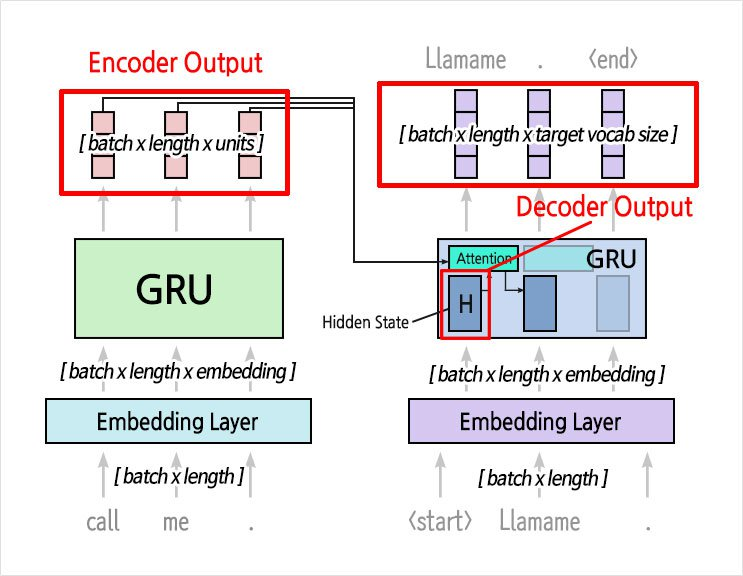

In [10]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [13]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [14]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [15]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 8894)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## Step 5. 훈련하기

In [18]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

### train_step 구현하기

In [19]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [21]:
from tqdm import tqdm    # tqdm
import random

# EPOCHS = 10
EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch  3: 100%|██████████| 375/375 [01:51<00:00,  3.36it/s, Loss 0.4021]


In [23]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch  3: 100%|██████████| 94/94 [00:09<00:00,  9.66it/s, Test Loss 0.6565]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


Input: can i have some coffee ?
Predicted translation: puedo tomar algo de caf ? <end> 


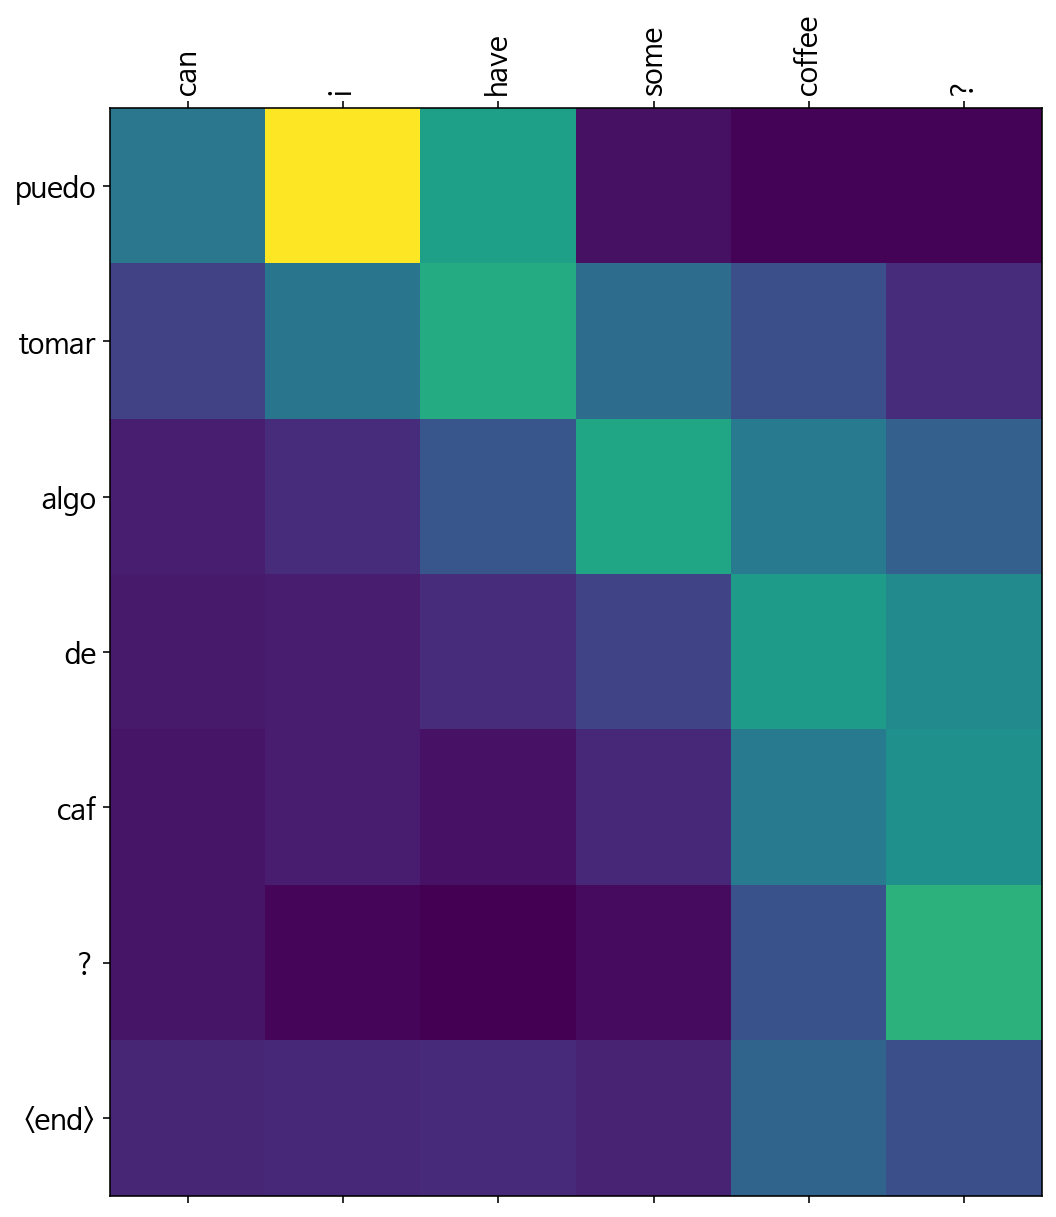

In [24]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)